https://www.tensorflow.org/tutorials/layers

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf
import cv2
import sys
import matplotlib
from matplotlib import pyplot as plt
import pylab as pl
import math
from sklearn.metrics import confusion_matrix
import helper.get_image as gi
from filters import GrayscaleNormalizer

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

tf.logging.set_verbosity(tf.logging.INFO)

# automatically reload imported modules
%load_ext autoreload
%autoreload 2

/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#load data
FOLDER_PATH = '..'
# random
train_size = 2000
test_size = 100
val_size = 40

# img_range = np.arange(1, 20001)
# X_train_pos_idx, X_test_pos_idx, X_val_pos_idx = gi.get_random_indices(img_range, train_size, test_size, val_size)
# X_train_neg_idx, X_test_neg_idx, X_val_neg_idx = gi.get_random_indices(img_range, train_size, test_size, val_size)

# X_train, Y_train = gi.get_concrete_data(X_train_pos_idx, X_train_neg_idx, path = FOLDER_PATH)
# X_test , Y_test  = gi.get_concrete_data(X_test_pos_idx, X_test_neg_idx, path = FOLDER_PATH)
# X_val  , Y_val   = gi.get_concrete_data(X_val_pos_idx, X_val_neg_idx, path = FOLDER_PATH)

# print( X_train.shape, Y_train.shape )
# print( X_test.shape , Y_test.shape  )
# print( X_val.shape  , Y_val.shape   )
#fixed from range
X_train, Y_train = gi.get_concrete_data(range(1601, 3601), range(1601, 3601), path = FOLDER_PATH)
X_test , Y_test  = gi.get_concrete_data(range(501 , 541 ), range(501 , 541 ), path = FOLDER_PATH)
X_val  , Y_val   = gi.get_concrete_data(range(1001, 1101), range(1001, 1101), path = FOLDER_PATH)

print( X_train.shape, Y_train.shape )
print( X_test.shape , Y_test.shape  )
print( X_val.shape  , Y_val.shape   )

(4000, 227, 227) (4000,)
(80, 227, 227) (80,)
(200, 227, 227) (200,)


In [8]:
def getTPTNRate(l,p):#label, predictions
    tn, fp, fn, tp = confusion_matrix(l, p).ravel()
    tpr = float(tp)/(float(tp) + float(fn))
    tnr=float(tn)/(float(tn) + float(fp))
    return tpr,tnr
# this is for training 
def run_model_TF(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    
    # have tensorflow compute accuracy
    predictions=tf.argmax(predict,1)
    correct_prediction = tf.equal(predictions, y)#array of true and false
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    
    actuals=y
    ones_like_actuals = tf.ones_like(actuals)#all elements set to 1
    zeros_like_actuals = tf.zeros_like(actuals) #all elements set to 0
    ones_like_predictions = tf.ones_like(predictions) #all elements set to 1
    zeros_like_predictions = tf.zeros_like(predictions) #all elements set to 0
    
    tp_op = tf.count_nonzero(predictions * actuals)
    tn_op = tf.count_nonzero((predictions - 1) * (actuals - 1))
    fp_op = tf.count_nonzero(predictions * (actuals - 1))
    fn_op = tf.count_nonzero((predictions - 1) * actuals)
 
    train_indicies = np.arange(Xd.shape[0])
    
    training_now = (training is not None)
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, tp_op, tn_op, fp_op, fn_op, correct_prediction,accuracy]
    if training_now:
        variables[-1] = training

    # counter 
    iter_cnt = 0
    # keep track of losses
    losses = []


    for e in range(epochs):
        # shuffle indicies
        np.random.shuffle(train_indicies)
        total_tp=0
        total_tn=0
        total_fp=0
        total_fn=0
        correct = 0

        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, tp, tn, fp, fn, corr,_= session.run(variables,feed_dict=feed_dict) #last variable will be automatically be None 


            print(tp,tn,fp,fn)
            total_tp+=tp
            total_tn+=tn
            total_fp+=fp 
            total_fn+=fn
            tpr = float(tp)/(float(tp) + float(fn))
#             fpr = float(fp)/(float(tp) + float(fn))
            tnr=float(tn)/(float(tn) + float(fp))
#             accuracy = (float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn))
            
#             recall = tpr
#             precision = float(tp)/(float(tp) + float(fp))
#             f1_score = (2.0 * (precision * recall)) / (precision + recall)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)

            corr = np.array(corr).astype(np.float32)
            
            correct += np.sum(corr)

            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g},tpr of {2:.2g},tnr of {3:.2g} and accuracy of {4:.2g}"\
                      .format(iter_cnt,loss,tpr,tnr,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_tpr = total_tp/(total_tp+total_fn)
        total_tnr=total_tn/(total_tn+total_fp)
        total_loss = np.sum(losses)/Xd.shape[0]
        total_correct = correct/Xd.shape[0]
        


        print("Epoch {0}, Overall loss = {1:.3g} tpr of {2:.3g},tnr of {3:.3g} and accuracy of {4:.3g}"\
              .format(e+1,total_loss,total_tpr,total_tnr,total_correct))
    
        
    if plot_losses:
        plt.plot(losses)
        plt.grid(True)
        plt.title('Epoch {} Loss'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
        plt.show()
            
    return total_loss,total_tpr,total_tnr,losses

Training
14 14 21 15
Iteration 0: with minibatch training loss = 1.36,tpr of 0.48,tnr of 0.4 and accuracy of 0.44
23 22 8 11
18 26 10 10
20 24 11 9
25 25 4 10
25 26 7 6
23 29 2 10
22 24 7 11
23 25 5 11
29 23 4 8
28 25 5 6
26 28 3 7
24 29 5 6
29 27 1 7
19 30 9 6
23 26 7 8
24 25 3 12
27 25 6 6
27 31 2 4
30 25 4 5
26 26 1 11
25 24 4 11
25 31 1 7
23 26 4 11
22 31 6 5
24 32 3 5
25 24 5 10
22 31 3 8
24 28 1 11
30 27 2 5
19 29 7 9
22 31 3 8
26 29 3 6
23 29 10 2
26 25 6 7
21 30 6 7
24 26 6 8
30 24 1 9
29 28 3 4
24 26 5 9
24 31 0 9
28 25 4 7
27 28 2 7
26 27 1 10
27 30 1 6
26 25 2 11
29 30 2 3
22 36 2 4
29 28 2 5
24 28 4 8
32 27 3 2
29 26 0 9
28 28 5 3
24 28 6 6
19 36 8 1
27 35 0 2
24 29 4 7
28 30 1 5
22 32 7 3
26 30 7 1
29 31 1 3
30 29 2 3
12 17 0 3
Epoch 1, Overall loss = 0.879 tpr of 0.78,tnr of 0.866 and accuracy of 0.823
24 36 1 3
31 29 0 4
28 30 1 5
33 23 2 6
27 32 2 3
27 33 1 3
23 36 1 4
30 30 1 3
31 26 3 4
31 27 0 6
29 29 0 6
26 33 3 2
24 34 3 3
27 30 2 5
29 29 2 4
29 27 4 4
25 36 1 2
28

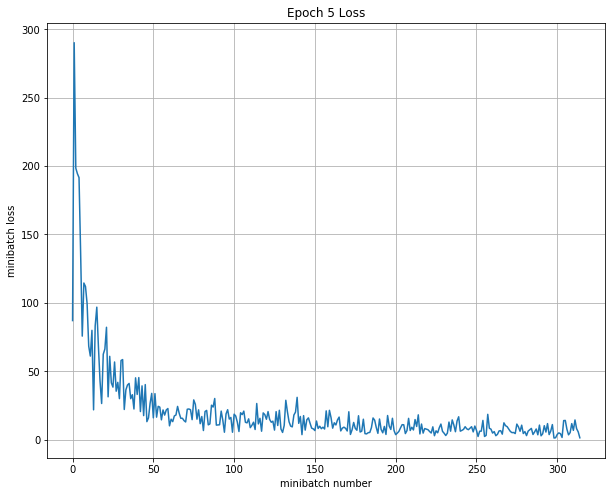

'trained_model/cnn_model2'

In [10]:
class CNN_model:
    def __init__(self,X_train,Y_train):
        self.X_train=X_train
        self.Y_train=Y_train
        
    def cnn_model_fn(self,X, labels, is_training):
        #1-layer model: conv-pool-fc-fc-softmax with batch normalization 
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
        input_layer = tf.reshape(X, [-1, 227, 227, 1])

        conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=8,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
        bn1act = tf.layers.batch_normalization(inputs=conv1, training=is_training)

        pool1 = tf.layers.max_pooling2d(inputs=bn1act, pool_size=[2, 2], strides=2)
       
  # Flatten tensor into a batch of vectors
        pool1_flat = tf.reshape(pool1, [-1, 113 * 113 * 8])

  # Dense Layer
  # Densely connected layer with 128 neurons
        dense = tf.layers.dense(inputs=pool1_flat, units=1024, activation=tf.nn.relu)
        bn2act = tf.layers.batch_normalization(inputs=dense, training=is_training)

  # Add dropout operation; 0.6 probability that element will be kept to avoid overfitting
        dropout = tf.layers.dropout(
      inputs=bn2act, rate=0.4, training=is_training)

  # Logits layer
  # Input Tensor Shape: [batch_size, 128]
  # Output Tensor Shape: [batch_size, 2]
        logits = tf.layers.dense(inputs=dropout, units=2,activation=None,name="logits")
        return logits


#load model
model=CNN_model(X_train,Y_train)

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 227, 227],name="X")
y = tf.placeholder(tf.int64, [None],name="y")
is_training = tf.placeholder(tf.bool,name="training")

y_out = model.cnn_model_fn(X,y,is_training)
# print(y_out)
# print(is_training)
total_loss = tf.losses.softmax_cross_entropy(logits=y_out, onehot_labels=tf.one_hot(y,2))
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(1e-4) #adam
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
print('Training')
run_model_TF(sess,y_out,mean_loss,X_train,Y_train,5,64,100,train_step,True)
#save the model
#the training is over 4000 data(2000 pos 2000 neg) over 5 epoch
saver.save(sess, 'trained_model/cnn_model2')




In [4]:
#this is to load the saved trained model

sess=tf.Session()    
#retrieve the model
saver = tf.train.import_meta_graph('trained_model/cnn_model2.meta')
saver.restore(sess, 'trained_model/cnn_model2')
graph = tf.get_default_graph()
stored_y_out = graph.get_tensor_by_name("logits/BiasAdd:0")
X = graph.get_tensor_by_name("X:0")
is_training=graph.get_tensor_by_name("training:0")

mypredictions=tf.argmax(stored_y_out,1)
print('Test')
#predicted result based on input
predicted_test=mypredictions.eval(feed_dict={X:X_test,is_training:False}, session=sess)
print(predicted_test)
print(Y_test)
tpr_test,tnr_test=getTPTNRate(Y_test,predicted_test)
print("true positive rate",tpr_test,"true negative rate",tnr_test)

INFO:tensorflow:Restoring parameters from trained_model/cnn_model2
Test
[1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
true positive rate 0.95 true negative rate 0.975


the model is based on https://ac.els-cdn.com/S1877705817304289/1-s2.0-S1877705817304289-main.pdf?_tid=918bcd97-2bcc-4ee7-ae31-44ea555c002b&acdnat=1523213163_a7fcbb7625fce5e50f0e1ea690f38c09

it has a structure of conv-conv-pool-conv-conv-pool-conv-conv-pool-fc-fc-softmax and each conv layer has a dropout to avoid overfitting

however, this model's prediction that has close to 0 true positive rate and close to 1 true negative rate (3 epoch on 1000 training data)

the model is improved by adding batch normalization after each conv layer.

In [ ]:
#unused
def cnn_model_fn_old(X, labels, is_training):

  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(X, [-1, 227, 227, 1])
    
    
#     conv1 = tf.layers.conv2d(
#       inputs=input_layer,
#       filters=16,
#       kernel_size=[11, 11],
#       padding="same",
#       activation=tf.nn.relu)
#     bn1act = tf.layers.batch_normalization(inputs=conv1, training=is_training)
#     dropout1 = tf.layers.dropout(
#       inputs=bn1act, rate=0.2, training=is_training)
#     conv2 = tf.layers.conv2d(
#       inputs=dropout1,
#       filters=32,
#       kernel_size=[5, 5],
#       padding="same",
#       activation=tf.nn.relu)
#     bn2act = tf.layers.batch_normalization(inputs=conv2, training=is_training)
#     dropout2 = tf.layers.dropout(
#       inputs=bn2act, rate=0.3, training=is_training)
#     pool1 = tf.layers.max_pooling2d(inputs=dropout2, pool_size=[3, 3], strides=2)
#     conv3 = tf.layers.conv2d(
#       inputs=pool1,
#       filters=32,
#       kernel_size=[5, 5],
#       padding="same",
#       activation=tf.nn.relu)
#     bn3act = tf.layers.batch_normalization(inputs=conv3, training=is_training)
#     dropout3 = tf.layers.dropout(
#       inputs=bn3act, rate=0.3, training=is_training)
#     conv4 = tf.layers.conv2d(
#       inputs=dropout3,
#       filters=32,
#       kernel_size=[3, 3],
#       padding="same",
#       activation=tf.nn.relu)
#     bn4act = tf.layers.batch_normalization(inputs=conv4, training=is_training)
#     dropout4 = tf.layers.dropout(
#       inputs=bn4act, rate=0.3, training=is_training)
#     pool2 = tf.layers.max_pooling2d(inputs=dropout4, pool_size=[3, 3], strides=2)
#     conv5 = tf.layers.conv2d(
#       inputs=pool2,
#       filters=32,
#       kernel_size=[3, 3],
#       padding="same",
#       activation=tf.nn.relu)
#     bn5act = tf.layers.batch_normalization(inputs=conv5, training=is_training)
#     dropout5 = tf.layers.dropout(
#       inputs=bn5act, rate=0.3, training=is_training)
#     conv6 = tf.layers.conv2d(
#       inputs=dropout5,
#       filters=32,
#       kernel_size=[3, 3],
#       padding="same",
#       activation=tf.nn.relu)
#     bn6act = tf.layers.batch_normalization(inputs=conv6, training=is_training)
#     dropout6 = tf.layers.dropout(
#       inputs=bn6act, rate=0.4, training=is_training)
#     pool3 = tf.layers.max_pooling2d(inputs=dropout6, pool_size=[3, 3], strides=2)
#     pool3_flat = tf.reshape(pool3, [-1, 27 * 27 * 32])
#     dense1 = tf.layers.dense(inputs=pool3_flat, units=128, activation=tf.nn.relu)
#     dropout6 = tf.layers.dropout(
#       inputs=dense1, rate=0.5, training=is_training)
#     logits = tf.layers.dense(inputs=dropout6, units=2,activation=None)
    
    
    
    
    

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 227, 227, 1]
  # Output Tensor Shape: [batch_size, 227, 227, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=8,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    bn1act = tf.layers.batch_normalization(inputs=conv1, training=is_training)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 227, 227, 32]
  # Output Tensor Shape: [batch_size, 113, 113, 32]
    pool1 = tf.layers.max_pooling2d(inputs=bn1act, pool_size=[2, 2], strides=2)
       

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 56, 56, 64]
  # Output Tensor Shape: [batch_size, 56 * 56 * 64]
    pool1_flat = tf.reshape(pool1, [-1, 113 * 113 * 8])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 56 * 56 * 64]
  # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool1_flat, units=128, activation=tf.nn.relu)
    bn2act = tf.layers.batch_normalization(inputs=dense, training=is_training)

  # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
      inputs=bn2act, rate=0.4, training=is_training)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 2]
    logits = tf.layers.dense(inputs=dropout, units=2,activation=None)

#   # Convolutional Layer #2
#   # Computes 64 features using a 5x5 filter.
#   # Padding is added to preserve width and height.
#   # Input Tensor Shape: [batch_size, 113, 113, 32]
#   # Output Tensor Shape: [batch_size, 113, 113, 64]
#     conv2 = tf.layers.conv2d(
#       inputs=pool1,
#       filters=64,
#       kernel_size=[5, 5],
#       padding="same",
#       activation=tf.nn.relu)
#     bn2act = tf.layers.batch_normalization(inputs=conv2, training=is_training)

#   # Pooling Layer #2
#   # Second max pooling layer with a 2x2 filter and stride of 2
#   # Input Tensor Shape: [batch_size, 113, 113, 64]
#   # Output Tensor Shape: [batch_size, 56, 56, 64]
#     pool2 = tf.layers.max_pooling2d(inputs=bn2act, pool_size=[2, 2], strides=2)
    
#     conv3 = tf.layers.conv2d(
#       inputs=pool2,
#       filters=64,
#       kernel_size=[5, 5],
#       padding="same",
#       activation=tf.nn.relu)
#     bn3act = tf.layers.batch_normalization(inputs=conv3, training=is_training)

#   # Pooling Layer #2
#   # Second max pooling layer with a 2x2 filter and stride of 2
#   # Input Tensor Shape: [batch_size, 113, 113, 64]
#   # Output Tensor Shape: [batch_size, 56, 56, 64]
#     pool2 = tf.layers.max_pooling2d(inputs=bn2act, pool_size=[2, 2], strides=2)
    
    
    

#   # Flatten tensor into a batch of vectors
#   # Input Tensor Shape: [batch_size, 56, 56, 64]
#   # Output Tensor Shape: [batch_size, 56 * 56 * 64]
#     pool2_flat = tf.reshape(pool2, [-1, 56 * 56 * 64])

#   # Dense Layer
#   # Densely connected layer with 1024 neurons
#   # Input Tensor Shape: [batch_size, 56 * 56 * 64]
#   # Output Tensor Shape: [batch_size, 1024]
#     dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
#     bn3act = tf.layers.batch_normalization(inputs=dense, training=is_training)

#   # Add dropout operation; 0.6 probability that element will be kept
#     dropout = tf.layers.dropout(
#       inputs=bn3act, rate=0.4, training=is_training)

#   # Logits layer
#   # Input Tensor Shape: [batch_size, 1024]
#   # Output Tensor Shape: [batch_size, 2]
#     logits = tf.layers.dense(inputs=dropout, units=2,activation=None)
    return logits
    



Training with 1000 training data entries 10 epoch, validate with 50 data entries and test with 100 data entries:

Validation

Epoch 1, Overall loss = 0.247 and accuracy of 0.94

Test

Epoch 1, Overall loss = 0.298 and accuracy of 0.89


# new test data
## conv-pool-fc(128)-fc-softmax model; training 5 epoches over 4000 data
true positive rate 0.6 true negative rate 1.0 (osillating loss)
## conv-pool-fc(1024)-fc-softmax model; training 5 epoches over 4000 data
true positive rate 0.975 true negative rate 0.975
true positive rate 0.5 true negative rate 1.0 (osillating loss)

# Old: may have overlapping
## conv-pool-fc-fc-softmax model; training 3 epoches over 2000 data
validation:true positive rate 0.8 true negative rate 0.975

test:true positive rate 0.85 true negative rate 0.99

## conv-pool-fc(1024)-fc-softmax model; training 4 epoches over 2000 data
validation:true positive rate 0.875 true negative rate 0.975

test:true positive rate 0.89 true negative rate 0.96

## conv-pool-fc(512)-fc-softmax model; training 4 epoches over 2000 data
validation:true positive rate 0.775 true negative rate 0.9

test:true positive rate 0.88 true negative rate 0.92

## conv-pool-fc(128)-fc-softmax model; training 4 epoches over 2000 data
validation:true positive rate 0.925 true negative rate 0.95/true positive rate 0.85 true negative rate 0.925

test:true positive rate 0.92 true negative rate 0.99/true positive rate 0.83 true negative rate 0.98

## conv-pool-fc(64)-fc-softmax model; training 4 epoches over 2000 data
validation:true positive rate 0.8 true negative rate 0.975

test:true positive rate 0.88 true negative rate 0.97

## conv-pool-fc-fc-softmax model; training 4 epoches over 4000 data
validation:true positive rate 0.925 true negative rate 1.0

test:true positive rate 0.94 true negative rate 0.98

## conv-pool-conv-pool-conv-pool-fc-fc-softmax model; training 3 epoches over 1000 data

validation:true positive rate 0.9 true negative rate 0.95

test:true positive rate 0.91 true negative rate 0.96

## conv-pool-conv-pool-conv-pool-fc-fc-softmax model; training 4 epoches over 2000 data
validation:true positive rate 0.975 true negative rate 0.95

test:true positive rate 0.95 true negative rate 0.93

## conv-conv-pool-conv-conv-pool-conv-conv-pool-fc-fc-softmax model; training 3 epoches over 1000 data

validation: true positive rate 0.9 true negative rate 0.95

test: true positive rate 0.96 true negative rate 0.95